## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape,512),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              Tanh-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
             ReLU-13                   [-1, 10]               0
Total params: 567,946
Trainable params:

Your experiments come here:

In [9]:
def train_model(model, train_loader, val_loader, loss_fn, opt, device, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch.cuda()).to(device)
            # move data to target device
            ### YOUR CODE HERE
            loss = loss_fn(y_pred, y_batch.cuda())
            loss.backward()
            opt.step()
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch.cuda()).to(device)
                # compute predictions
                ### YOUR CODE HERE
                loss = loss_fn(y_pred, y_batch.cuda())
                ep_val_loss.append(loss.cpu())
                accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch.cuda()) / len(y_batch)
                # y_pred = ### YOUR CODE HERE
                ep_val_accuracy.append(accuracy.cpu())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [10]:
from torch import optim
from torch.nn import CrossEntropyLoss
import time

model = TinyNeuralNetwork().to(device, dtype=torch.float32)
opt = optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, device, 10)

Epoch 1 of 10 took 12.888s
	  training loss: 0.677202
	validation loss: 0.438097
	validation accuracy: 0.844
Epoch 2 of 10 took 8.508s
	  training loss: 0.446862
	validation loss: 0.423005
	validation accuracy: 0.844
Epoch 3 of 10 took 8.401s
	  training loss: 0.408928
	validation loss: 0.378496
	validation accuracy: 0.863
Epoch 4 of 10 took 8.479s
	  training loss: 0.386396
	validation loss: 0.375971
	validation accuracy: 0.862
Epoch 5 of 10 took 8.496s
	  training loss: 0.371126
	validation loss: 0.360072
	validation accuracy: 0.869
Epoch 6 of 10 took 8.577s
	  training loss: 0.357456
	validation loss: 0.350350
	validation accuracy: 0.874
Epoch 7 of 10 took 8.514s
	  training loss: 0.349960
	validation loss: 0.345161
	validation accuracy: 0.875
Epoch 8 of 10 took 8.469s
	  training loss: 0.340681
	validation loss: 0.351179
	validation accuracy: 0.872
Epoch 9 of 10 took 8.574s
	  training loss: 0.331351
	validation loss: 0.333386
	validation accuracy: 0.879
Epoch 10 of 10 took 9.141s


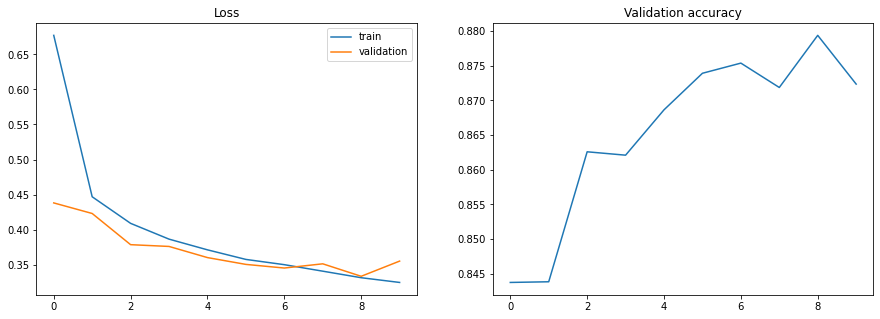

In [11]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

plot_train_process(train_loss, val_loss, val_accuracy)

Ошибка модели на трейне и валидации практически одинаковы

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Sigmoid-3                  [-1, 512]               0
            Linear-4                  [-1, 128]          65,664
              Tanh-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.81
----------------------------------------------------------------


In [14]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

train_loss_overfit, val_loss_overfit, val_accuracy_overfit = train_model(model, train_loader, test_loader, loss_func, opt, device, 40)

Epoch 1 of 40 took 8.201s
	  training loss: 0.528664
	validation loss: 0.421644
	validation accuracy: 0.845
Epoch 2 of 40 took 8.033s
	  training loss: 0.364456
	validation loss: 0.388494
	validation accuracy: 0.860
Epoch 3 of 40 took 8.092s
	  training loss: 0.327138
	validation loss: 0.361368
	validation accuracy: 0.870
Epoch 4 of 40 took 8.046s
	  training loss: 0.303350
	validation loss: 0.341510
	validation accuracy: 0.875
Epoch 5 of 40 took 8.978s
	  training loss: 0.284165
	validation loss: 0.324735
	validation accuracy: 0.883
Epoch 6 of 40 took 8.064s
	  training loss: 0.269715
	validation loss: 0.328019
	validation accuracy: 0.881
Epoch 7 of 40 took 8.148s
	  training loss: 0.256431
	validation loss: 0.346354
	validation accuracy: 0.879
Epoch 8 of 40 took 8.092s
	  training loss: 0.246809
	validation loss: 0.347571
	validation accuracy: 0.872
Epoch 9 of 40 took 8.096s
	  training loss: 0.237616
	validation loss: 0.327334
	validation accuracy: 0.885
Epoch 10 of 40 took 8.140s
	

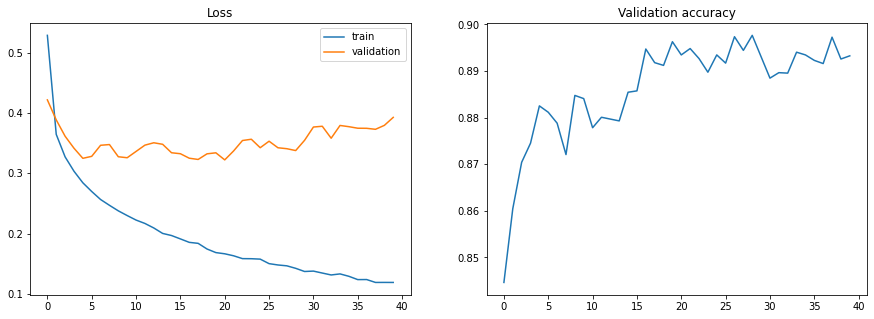

In [15]:
plot_train_process(train_loss_overfit, val_loss_overfit, val_accuracy_overfit)

Ошибки на трейне и тесте сильно различаются

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [16]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Dropout(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [17]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Sigmoid-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 128]          65,664
              Tanh-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 10]           1,290
Total params: 470,154
Trainable params: 470,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.79
Estimated T

In [18]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

train_loss_fixed, val_loss_fixed, val_accuracy_fixed = train_model(model, train_loader, test_loader, loss_func, opt, device, 10)

Epoch 1 of 10 took 8.715s
	  training loss: 0.582897
	validation loss: 0.411368
	validation accuracy: 0.851
Epoch 2 of 10 took 8.455s
	  training loss: 0.457703
	validation loss: 0.396299
	validation accuracy: 0.854
Epoch 3 of 10 took 8.649s
	  training loss: 0.427611
	validation loss: 0.369324
	validation accuracy: 0.868
Epoch 4 of 10 took 9.448s
	  training loss: 0.416350
	validation loss: 0.358989
	validation accuracy: 0.870
Epoch 5 of 10 took 8.573s
	  training loss: 0.403214
	validation loss: 0.369981
	validation accuracy: 0.870
Epoch 6 of 10 took 8.469s
	  training loss: 0.392681
	validation loss: 0.354700
	validation accuracy: 0.875
Epoch 7 of 10 took 8.573s
	  training loss: 0.387595
	validation loss: 0.368876
	validation accuracy: 0.869
Epoch 8 of 10 took 8.562s
	  training loss: 0.381377
	validation loss: 0.350974
	validation accuracy: 0.876
Epoch 9 of 10 took 8.462s
	  training loss: 0.371236
	validation loss: 0.353301
	validation accuracy: 0.877
Epoch 10 of 10 took 8.464s
	

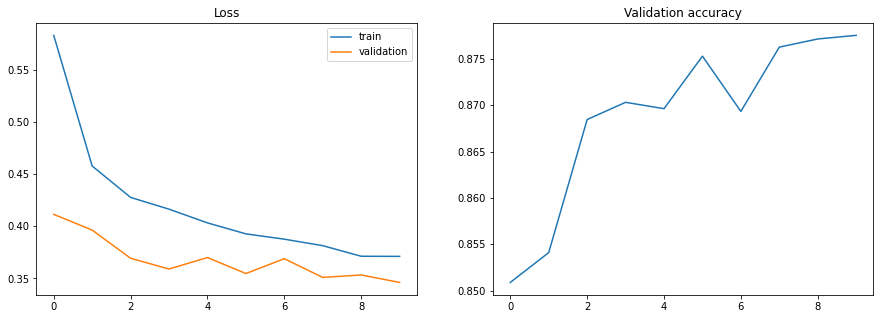

In [19]:
plot_train_process(train_loss_fixed, val_loss_fixed, val_accuracy_fixed)

Трейн и валидационная выборки намного ближе, значит смогли преодолеть переобучение путём добавление Dropout и BatchNormalization

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. Использование графических процессоров сильно ускоряет время обучения модели
2. Модель можно легко переобучить используя либо малое количество слоёв, либо слишком больше
3. Решить проблему переобучения можно с помощью таких техник как Dropout и/или BatchNormalization
4. Большое количество эпох так же ведёт к переобучению, этот параметр нужно очень аккуратно подбирать, т.к. если модель много раз видела одни и те же картинки, то она научится различать только их
5. Большой learning rate так же не будет способствовать обучению, т.к. мы можем перескочить через оптимум